In [1]:
import glob
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal

# Division de impulso en partes Early-Late

In [2]:
rir_path = '/home/mrtn/Documents/TESIS/de-reverb/bases de datos/data/impulsos'
rir_list = glob.glob(rir_path+'/**/*.wav', recursive=True)
rir, fs = librosa.load(rir_list[0], sr=16000)

speech_path = '/home/mrtn/Documents/TESIS/de-reverb/bases de datos/data/speech/train-clean-100'
speech_list = glob.glob(speech_path+'/**/*.flac', recursive=True)
speech, fs = librosa.load(speech_list[0], sr=16000)
speech = speech[:16000]

In [56]:
rir = rir[abs(rir).argmax():] #Descarto delay inicial

#division Early - Late 
Q_e = 512
rir_early = rir[:Q_e]
rir_late = rir[Q_e:]
assert rir.tolist() == np.concatenate((rir_early, rir_late)).tolist()
rir_late = np.concatenate((np.zeros(len(rir_early)),rir_late))


In [57]:
reverb = signal.fftconvolve(speech, rir)[:len(speech)]
reverb_early = signal.fftconvolve(speech, rir_early)[:len(speech)]
reverb_late = signal.fftconvolve(speech, rir_late)[:len(speech)]

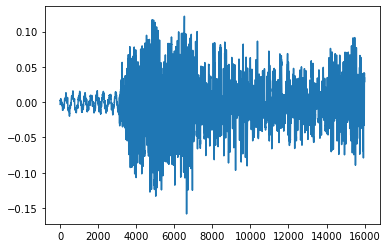

In [58]:
plt.plot(reverb_early+reverb_late,label='Suma')

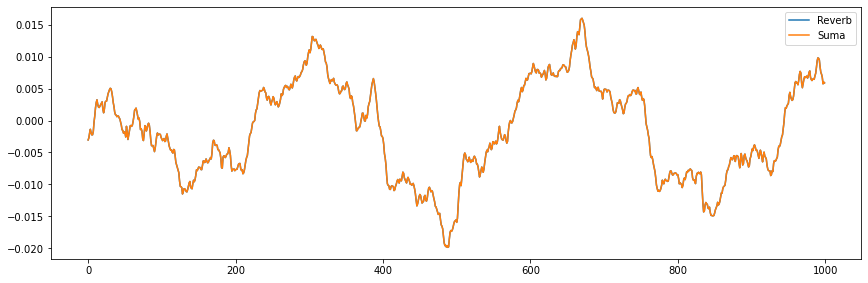

In [59]:
plt.plot(reverb[:1000], label='Reverb')
plt.plot((reverb_early+reverb_late)[:1000],label='Suma')
plt.legend()
plt.subplots_adjust(right=2, top=1)

CONCLUSION: Para poder hacer esa descomposicion en partes early y late, la parte late tiene que verse padeada al principio con un zero-padding del largo de la parte early. De lo contrario, esta parte late seria como una nueva parte early.


# Obtencion de parte Early del speech mediante convolucion

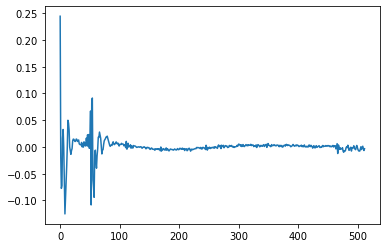

In [60]:
plt.plot(rir_early) #32 muestras

In [61]:
#espectrogramas 
speech_stft = abs(librosa.stft(speech, win_length=512, hop_length=128))
early_stft = abs(librosa.stft(reverb_early, win_length=512, hop_length=128))

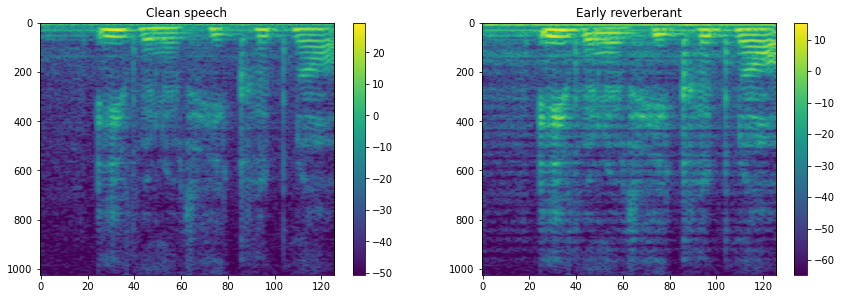

In [62]:
plt.subplot(1,2,1)
plt.imshow(librosa.amplitude_to_db(speech_stft), aspect='auto')
plt.title('Clean speech')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(librosa.amplitude_to_db(early_stft), aspect='auto')
plt.title('Early reverberant')
plt.colorbar()
plt.subplots_adjust(right=2, top=1)

Para valores de Q_e chicos (por ejemplo 32) No se ven muchas diferencias en los espectros. Pero para Q mas grandes (probar Q_e = 128) aparece un patron como de filtro peine en el espectro, lo cual tiene sentido al convolucionar con una ventana corta en tiempo cuya respuesta en frecuencia sera similar a la de un pulso rectangular en cierta medida. Estas cuestiones deben considerarse exhaustivamente antes de decidir trabajar con espectro correspondientes a partes tempranas de las RIR. 
CONCLUSION: Si voy a trabajar con partes early-late, usar ventanas de 32 puntos para una fs=16kHz deberia funcionar, teniendo en cuenta descartar el delay inicial. 